## Regression Trees — End-to-End Workflow

We’ll build a supervised regression pipeline with Regression Trees (CART):
	•	Data Exploration: load, inspect, visualize
	•	Preprocessing: train/test split, (optional) imputation
	•	Modeling: from-scratch SimpleDecisionTreeRegressor and scikit-learn DecisionTreeRegressor, plus tuning
	•	Evaluation: MAE, MSE, RMSE, R^2, residual plots, parity plots, feature importances, and tree text rules

Concept: A regression tree recursively splits the feature space to minimize within-node squared error (variance), predicting the mean target in each leaf.

## Setup

In [1]:
# Imports & reproducibility
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Optional, Tuple, Union, List, Dict
from IPython.display import display

# sklearn utilities
from sklearn.datasets import fetch_california_housing, load_diabetes
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Optional viz
try:
    import seaborn as sns
except Exception:
    sns = None

np.random.seed(42)
plt.rcParams["figure.figsize"] = (6.8, 4.2)
plt.rcParams["axes.grid"] = True

## Data Exploration

We’ll try California Housing (bigger, nicer), and fallback to Diabetes if fetching isn’t available. We’ll inspect shapes, summaries, target distribution, and correlations.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/datasets/_base.py:1518: UserWarning: Retry downloading from url: https://ndownloader.figshare.com/files/5976036
  warnings.warn(f"Retry downloading from url: {remote.url}")


Could not fetch California Housing; falling back to Diabetes. Reason: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:997)>
Dataset: Diabetes
Shape: (442, 11)


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000
mean,-2.511817e-19,1.230790e-17,-2.245564e-16,-4.797570e-17,-1.381499e-17,3.918434e-17,-5.777179e-18,-9.042540e-18,9.293722e-17,1.130318e-17,152.133484
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,77.093005
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123988e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260971e-01,-1.377672e-01,25.000000
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665608e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324559e-02,-3.317903e-02,87.000000
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670422e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947171e-03,-1.077698e-03,140.500000
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564379e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243232e-02,2.791705e-02,211.500000
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320436e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335973e-01,1.356118e-01,346.000000


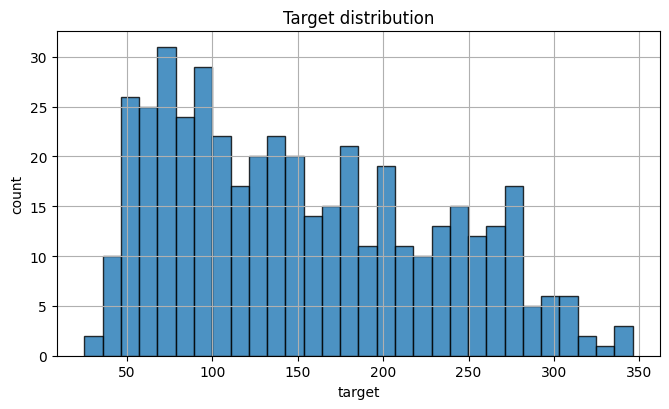

,corr_with_target
target,1.000000
bmi,0.586450
s5,0.565883
bp,0.441482
s4,0.430453
s6,0.382483
s1,0.212022
age,0.187889
s2,0.174054
sex,0.043062


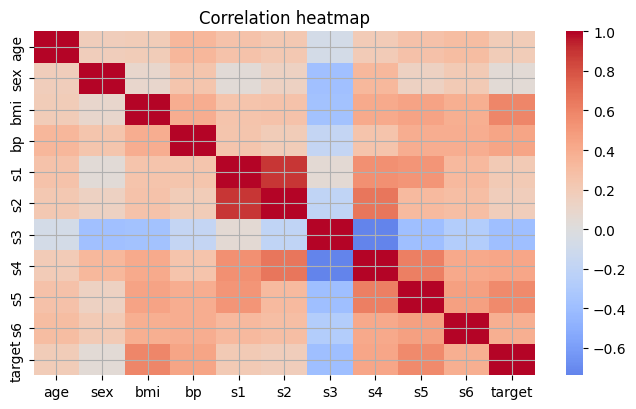

In [2]:
# Load dataset (California Housing -> fallback to Diabetes)
dataset_name = "California Housing"
try:
    cali = fetch_california_housing(as_frame=True)
    X: pd.DataFrame = cali.data.copy()
    y: pd.Series = pd.Series(cali.target, name="target")  # median house value (in 100k$)
except Exception as e:
    print("Could not fetch California Housing; falling back to Diabetes. Reason:", e)
    dataset_name = "Diabetes"
    diab = load_diabetes(as_frame=True)
    X = diab.data.copy()
    y = pd.Series(diab.target, name="target")

df = X.copy()
df["target"] = y

print(f"Dataset: {dataset_name}")
print("Shape:", df.shape)
display(df.head())
display(df.describe())

# Target distribution
plt.hist(y, bins=30, edgecolor="k", alpha=0.8)
plt.title("Target distribution")
plt.xlabel("target"); plt.ylabel("count")
plt.tight_layout(); plt.show()

# Correlations with target
corr_t = df.corr(numeric_only=True)["target"].sort_values(ascending=False)
display(corr_t.to_frame("corr_with_target"))

# Optional full heatmap
if sns is not None:
    try:
        sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm", center=0)
        plt.title("Correlation heatmap")
        plt.tight_layout(); plt.show()
    except Exception as e:
        print("Skipping heatmap:", e)
else:
    print("Seaborn not installed; skipping heatmap.")

## Preprocessing
	•	Train/Test split (regression → no stratify)
	•	Trees don’t need scaling; we’ll keep a median imputer for robustness.

In [3]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)
print("Train:", X_train.shape, " Test:", X_test.shape)

Train: (331, 10)  Test: (111, 10)


## Modeling

We’ll train:
	1.	From-scratch Regression Tree (variance reduction / MSE)
	2.	scikit-learn DecisionTreeRegressor in a Pipeline
We’ll also run a small GridSearchCV to tune depth/leaves.

In [4]:
from dataclasses import dataclass

@dataclass
class _RNode:
    mse: float
    num_samples: int
    value: float                    # mean target in the node
    feature_index: Optional[int] = None
    threshold: Optional[float] = None
    left: Optional["_RNode"] = None
    right: Optional["_RNode"] = None

class SimpleDecisionTreeRegressor:
    """
    Minimal CART-style Regression Tree using MSE (variance) reduction.
    - Splits choose feature/threshold that minimize weighted MSE of children.
    - Leaf prediction = mean(y) in leaf.
    NOTE: Educational; for production, prefer sklearn's DecisionTreeRegressor.
    """
    def __init__(
        self,
        max_depth: Optional[int] = None,
        min_samples_split: int = 2,
         min_samples_leaf: int = 1,
    ):
        self.max_depth = max_depth
        self.min_samples_split = int(min_samples_split)
        self.min_samples_leaf = int(min_samples_leaf)
        self.n_features_: Optional[int] = None
        self.tree_: Optional[_RNode] = None

    def fit(self, X: Union[pd.DataFrame, np.ndarray], y: Union[pd.Series, np.ndarray]):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float)
        self.n_features_ = X.shape[1]
        self.tree_ = self._grow(X, y, depth=0)
        return self

    def predict(self, X: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        X = np.asarray(X, dtype=float)
        return np.array([self._predict_row(row) for row in X], dtype=float)

    # ---- internals ----
    def _node_mse(self, y: np.ndarray) -> float:
        # mean squared error relative to the node's mean
        if y.size == 0:
            return 0.0
        mu = y.mean()
        return float(((y - mu) ** 2).mean())

    def _best_split(self, X: np.ndarray, y: np.ndarray) -> Tuple[Optional[int], Optional[float]]:
        m, n = X.shape
        if m < self.min_samples_split:
            return None, None

        # Precompute totals for variance math
        total_sum = y.sum()
        total_sq_sum = (y ** 2).sum()

        best_score = np.inf
        best_idx, best_thr = None, None

        for j in range(n):
            order = np.argsort(X[:, j])
            xj = X[order, j]
            yj = y[order]

            # cumulative sums for fast left/right stats
            csum = 0.0
            csum_sq = 0.0

            for i in range(1, m):
                yi_prev = yj[i - 1]
                csum += yi_prev
                csum_sq += yi_prev * yi_prev

                # skip identical thresholds
                if xj[i] == xj[i - 1]:
                    continue

                n_left = i
                n_right = m - i
                if n_left < self.min_samples_leaf or n_right < self.min_samples_leaf:
                    continue

                sum_left = csum
                sum_right = total_sum - csum

                sq_left = csum_sq
                sq_right = total_sq_sum - csum_sq

                # MSE = E[y^2] - (E[y])^2
                mean_left = sum_left / n_left
                mean_right = sum_right / n_right
                mse_left = (sq_left / n_left) - (mean_left ** 2)
                mse_right = (sq_right / n_right) - (mean_right ** 2)
                weighted_mse = (n_left * mse_left + n_right * mse_right) / m

                if weighted_mse < best_score:
                    best_score = weighted_mse
                    best_idx = j
                    best_thr = 0.5 * (xj[i] + xj[i - 1])

        return best_idx, best_thr

    def _grow(self, X: np.ndarray, y: np.ndarray, depth: int) -> _RNode:
        node = _RNode(
            mse=self._node_mse(y),
            num_samples=y.size,
            value=float(y.mean()) if y.size else 0.0,
        )
        depth_ok = True if self.max_depth is None else (depth < self.max_depth)
        if depth_ok:
            idx, thr = self._best_split(X, y)
            if idx is not None:
                left_mask = X[:, idx] < float(thr)
                X_l, y_l = X[left_mask], y[left_mask]
                X_r, y_r = X[~left_mask], y[~left_mask]
                if y_l.size and y_r.size:
                    node.feature_index = idx
                    node.threshold = float(thr)
                    node.left = self._grow(X_l, y_l, depth + 1)
                    node.right = self._grow(X_r, y_r, depth + 1)
        return node

    def _traverse(self, row: np.ndarray) -> _RNode:
        node = self.tree_
        while node and node.left is not None:
            if row[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node

    def _predict_row(self, row: np.ndarray) -> float:
        leaf = self._traverse(row)
        return leaf.value

In [5]:
# Build models
tree_scratch = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("tree", SimpleDecisionTreeRegressor(
        max_depth=6, min_samples_split=4, min_samples_leaf=2
    ))
])

tree_sklearn = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("dtr", DecisionTreeRegressor(
        max_depth=None, random_state=42
    ))
])

tree_scratch.fit(X_train, y_train)
tree_sklearn.fit(X_train, y_train)
print("Fitted: Simple (scratch) & sklearn trees")

Fitted: Simple (scratch) & sklearn trees


## Hyperparameter Tuning (sklearn)

We’ll run a compact grid over max_depth, min_samples_leaf, and min_samples_split.

In [6]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("dtr", DecisionTreeRegressor(random_state=42))
    ]),
    param_grid={
        "dtr__max_depth": [3, 5, 7, None],
        "dtr__min_samples_leaf": [1, 3, 5, 10],
        "dtr__min_samples_split": [2, 4, 8]
    },
    scoring="r2",
    cv=cv,
    n_jobs=-1
)

grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
print("Best CV R^2:", grid.best_score_)
tree_best = grid.best_estimator_

Best params: {'dtr__max_depth': 3, 'dtr__min_samples_leaf': 10, 'dtr__min_samples_split': 2}
Best CV R^2: 0.21440614840324299


## Evaluation

We’ll report MAE, MSE, RMSE, and R^2; show residual vs fitted and parity plots.
We’ll also print the tree rules (sklearn) and feature importances.

In [7]:
def regression_report(name: str, y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"\n=== {name} ===")
    print(f"MAE:  {mae: .4f}")
    print(f"MSE:  {mse: .4f}")
    print(f"RMSE: {rmse: .4f}")
    print(f"R^2:  {r2: .4f}")
    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}

def plot_residuals(y_true: np.ndarray, y_pred: np.ndarray, title: str):
    resid = y_true - y_pred
    plt.scatter(y_pred, resid, edgecolor="k", alpha=0.7)
    plt.axhline(0, color="k", lw=1)
    plt.xlabel("Predicted")
    plt.ylabel("Residual (y - ŷ)")
    plt.title(title)
    plt.tight_layout(); plt.show()

def plot_parity(y_true: np.ndarray, y_pred: np.ndarray, title: str):
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    plt.scatter(y_true, y_pred, edgecolor="k", alpha=0.7)
    plt.plot(lims, lims, "k--", lw=1)
    plt.xlabel("True y")
    plt.ylabel("Predicted ŷ")
    plt.title(title)
    plt.tight_layout(); plt.show()


=== Tree (scratch) ===
MAE:   54.3517
MSE:   4696.9575
RMSE:  68.5344
R^2:   0.1506

=== Tree (sklearn) ===
MAE:   58.8378
MSE:   5941.7027
RMSE:  77.0824
R^2:  -0.0745

=== Tree (tuned) ===
MAE:   44.4551
MSE:   3154.4786
RMSE:  56.1647
R^2:   0.4295


,MAE,MSE,RMSE,R2
Tree (scratch),54.351656,4696.957493,68.534353,0.150593
Tree (sklearn),58.837838,5941.702703,77.082441,-0.074509
Tree (tuned),44.455138,3154.478646,56.164746,0.429538


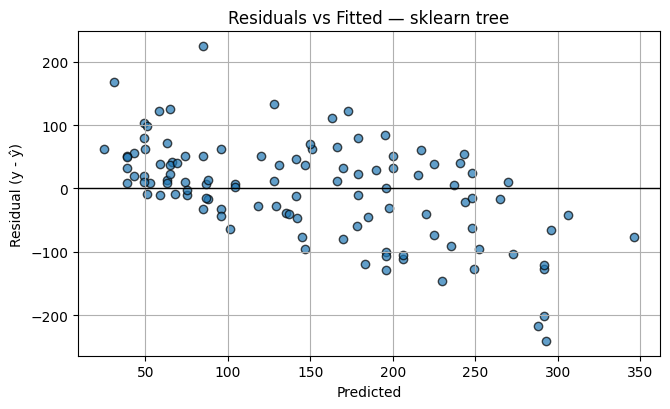

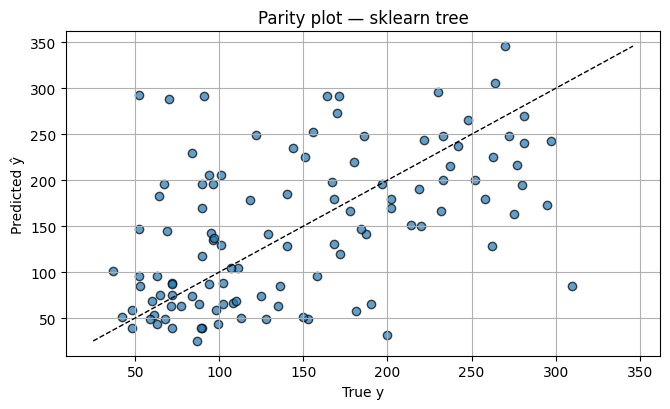

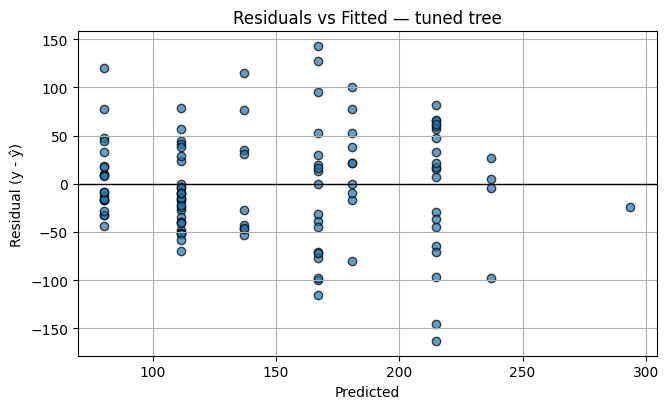

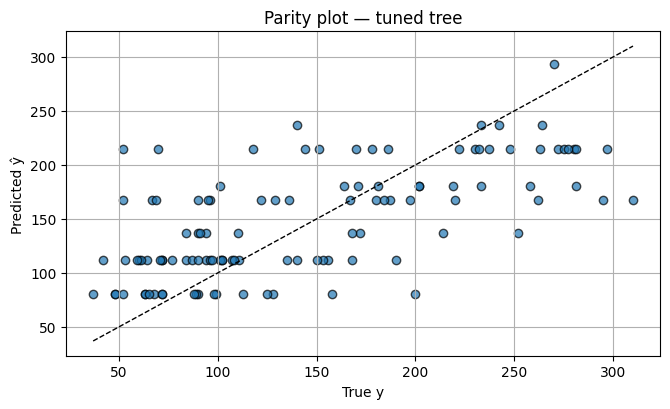

In [8]:
# Predictions
y_pred_scratch = tree_scratch.predict(X_test)
y_pred_sklearn = tree_sklearn.predict(X_test)
y_pred_best = tree_best.predict(X_test)

# Reports
metrics = {}
metrics["Tree (scratch)"] = regression_report("Tree (scratch)", y_test.to_numpy(), y_pred_scratch)
metrics["Tree (sklearn)"] = regression_report("Tree (sklearn)", y_test.to_numpy(), y_pred_sklearn)
metrics["Tree (tuned)"] = regression_report("Tree (tuned)", y_test.to_numpy(), y_pred_best)

display(pd.DataFrame(metrics).T)

# Plots
plot_residuals(y_test.to_numpy(), y_pred_sklearn, "Residuals vs Fitted — sklearn tree")
plot_parity(y_test.to_numpy(), y_pred_sklearn, "Parity plot — sklearn tree")

plot_residuals(y_test.to_numpy(), y_pred_best, "Residuals vs Fitted — tuned tree")
plot_parity(y_test.to_numpy(), y_pred_best, "Parity plot — tuned tree")

,importance
bmi,0.414489
s5,0.139686
bp,0.077683
s6,0.075648
s1,0.074915
s2,0.059517
s3,0.057249
age,0.050052
s4,0.031379
sex,0.019382


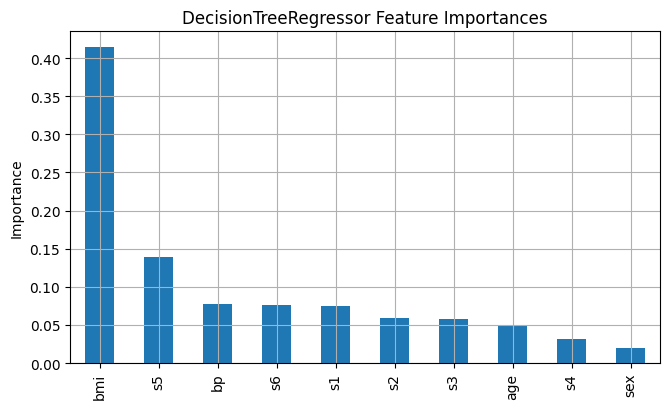

,importance
bmi,0.730734
s5,0.188990
bp,0.061456
s2,0.018820
age,0.000000
sex,0.000000
s1,0.000000
s3,0.000000
s4,0.000000
s6,0.000000


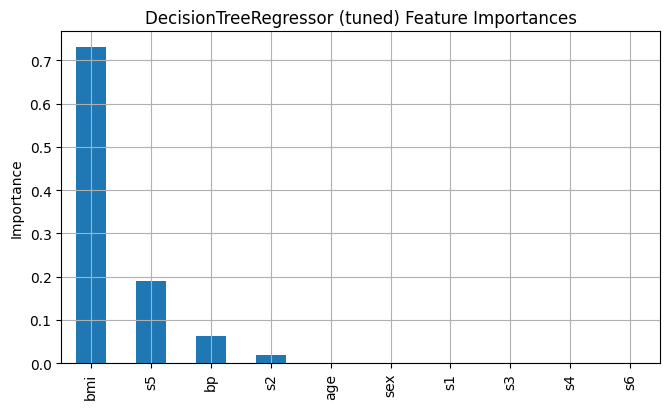

In [9]:
# Feature importances (only for sklearn trees)
def plot_importances(model, step_name: str, feature_names: List[str], title: str):
    try:
        inner = model.named_steps[step_name]
        importances = getattr(inner, "feature_importances_", None)
        if importances is None:
            print(f"No feature_importances_ for {title}")
            return
        imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
        display(imp.to_frame("importance").head(15))
        imp.head(25).plot(kind="bar")
        plt.title(title)
        plt.ylabel("Importance")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not plot importances for {title}:", e)

plot_importances(tree_sklearn, "dtr", list(X.columns), "DecisionTreeRegressor Feature Importances")
plot_importances(tree_best, "dtr", list(X.columns), "DecisionTreeRegressor (tuned) Feature Importances")

In [10]:
# Textual tree rules (limit depth for readability)
try:
    inner = tree_best.named_steps["dtr"]
    txt = export_text(inner, feature_names=list(X.columns), max_depth=3)
    print("Tree (tuned) — first levels:\n")
    print(txt)
except Exception as e:
    print("Could not export text tree:", e)

Tree (tuned) — first levels:

|--- bmi <= 0.01
|   |--- s5 <= 0.01
|   |   |--- s5 <= -0.04
|   |   |   |--- value: [80.29]
|   |   |--- s5 >  -0.04
|   |   |   |--- value: [111.57]
|   |--- s5 >  0.01
|   |   |--- bmi <= -0.02
|   |   |   |--- value: [137.10]
|   |   |--- bmi >  -0.02
|   |   |   |--- value: [180.75]
|--- bmi >  0.01
|   |--- bmi <= 0.07
|   |   |--- bp <= 0.02
|   |   |   |--- value: [167.19]
|   |   |--- bp >  0.02
|   |   |   |--- value: [215.04]
|   |--- bmi >  0.07
|   |   |--- s2 <= 0.02
|   |   |   |--- value: [293.67]
|   |   |--- s2 >  0.02
|   |   |   |--- value: [237.30]



## Depth vs Validation Curve

Deeper trees can overfit. Let’s see cross-validated R^2 vs max_depth.

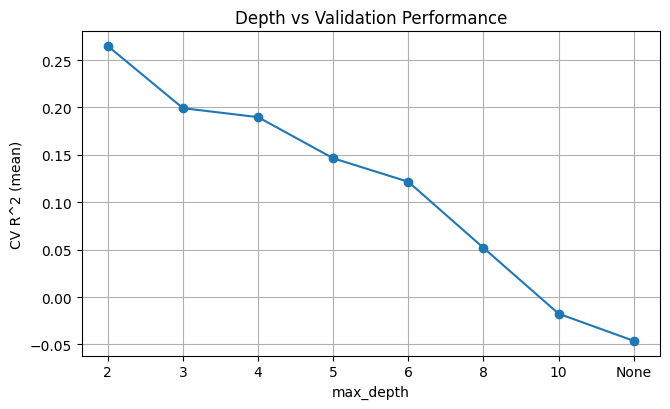

In [11]:
from sklearn.model_selection import cross_val_score

depths = [2, 3, 4, 5, 6, 8, 10, None]
scores = []
for d in depths:
    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("dtr", DecisionTreeRegressor(max_depth=d, random_state=42))
    ])
    cv_scores = cross_val_score(pipe, X_train, y_train, cv=KFold(5, shuffle=True, random_state=42), scoring="r2", n_jobs=-1)
    scores.append(cv_scores.mean())

plt.plot([str(d) for d in depths], scores, marker="o")
plt.xlabel("max_depth")
plt.ylabel("CV R^2 (mean)")
plt.title("Depth vs Validation Performance")
plt.tight_layout(); plt.show()

## Key Takeaways
	•	Regression Trees split features to minimize within-node squared error; leaves predict the mean.
	•	They capture nonlinearities & interactions without feature scaling.
	•	Control complexity with max_depth, min_samples_leaf, and min_samples_split; tune them with CV to avoid over/underfitting.
	•	Inspect residuals and parity plots; use feature importances and tree rules for interpretability.
	•	For better accuracy/robustness, try tree ensembles (Random Forests, Gradient Boosting).